In [4]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook as tqdm_notebook

from data_functions import *
from metric_functions import *
from helper_functions import *
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hiperparametry

In [2]:
dataset = torch.load("final_data.tar")
train, val = trai_val_split(dataset, 0.8)

In [3]:
n_convs_values = [2, 5, 10, 20]
kernel_size_values = [3, 5, 7, 9]
stride_values = [1, 2, 3, 5]
padding_values = [1, 2, 3, 5]
n_channels_values = [16, 32, 64, 128]

In [4]:
res = pd.DataFrame(columns=["n_convs", "kernel_size", "stride", "padding", "n_channels", "train_loss", "train_acc", "val_acc", "overfit"])
nets = {}

### Liczba warstw konwolucyjnych

In [5]:
for n_convs in tqdm_notebook.tqdm(n_convs_values):
    n_channels = 10
    stride = 1
    padding = 1
    kernel_size = 3
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 25, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_195474/2431415162.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_res])


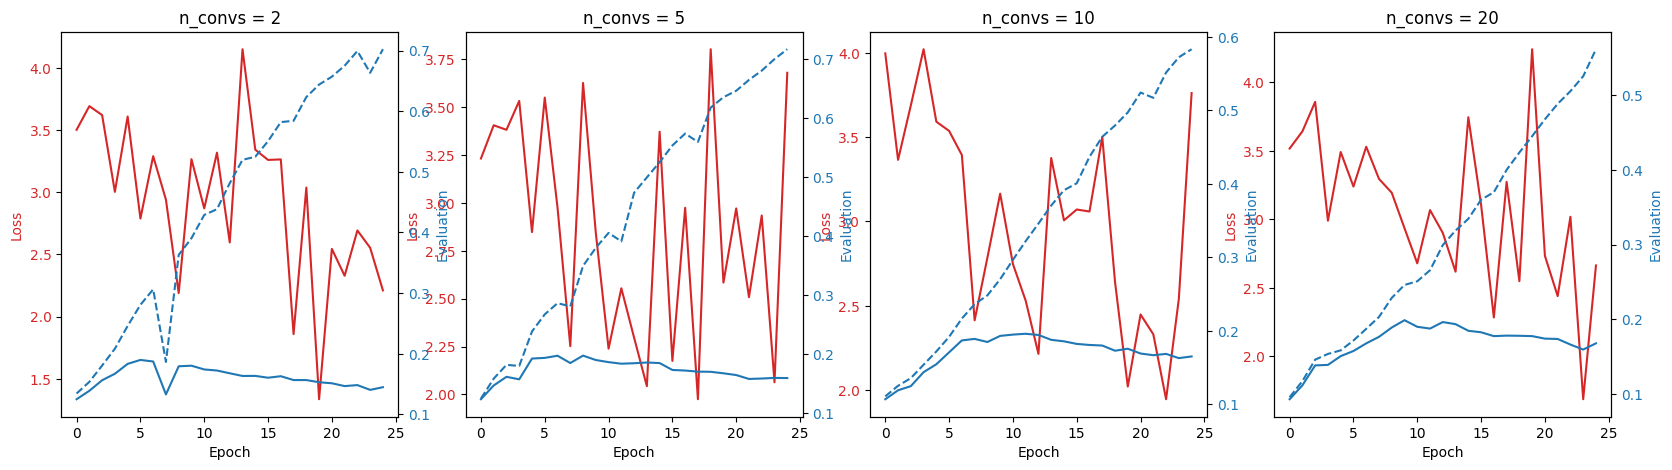

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, n_convs in enumerate(n_convs_values):
    iters = [i for i in range(25)]
    loss_hist = res[res["n_convs"] == n_convs]["train_loss"].values[0]
    train_acc = res[res["n_convs"] == n_convs]["train_acc"].values[0]
    val_acc = res[res["n_convs"] == n_convs]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"n_convs = {n_convs}")

- Wraz ze zwiększeniem liczby wartstw konwolucyjnych model robi się przetrenowany
- Trzeba polepszyć inne parametry żeby poprawić uogólnianie modelu

### Kernel size

In [6]:
for kernel_size in tqdm_notebook.tqdm(kernel_size_values):
    n_channels = 10
    stride = 1
    padding = 1
    n_convs = 3
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_384177/2691876052.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_res])


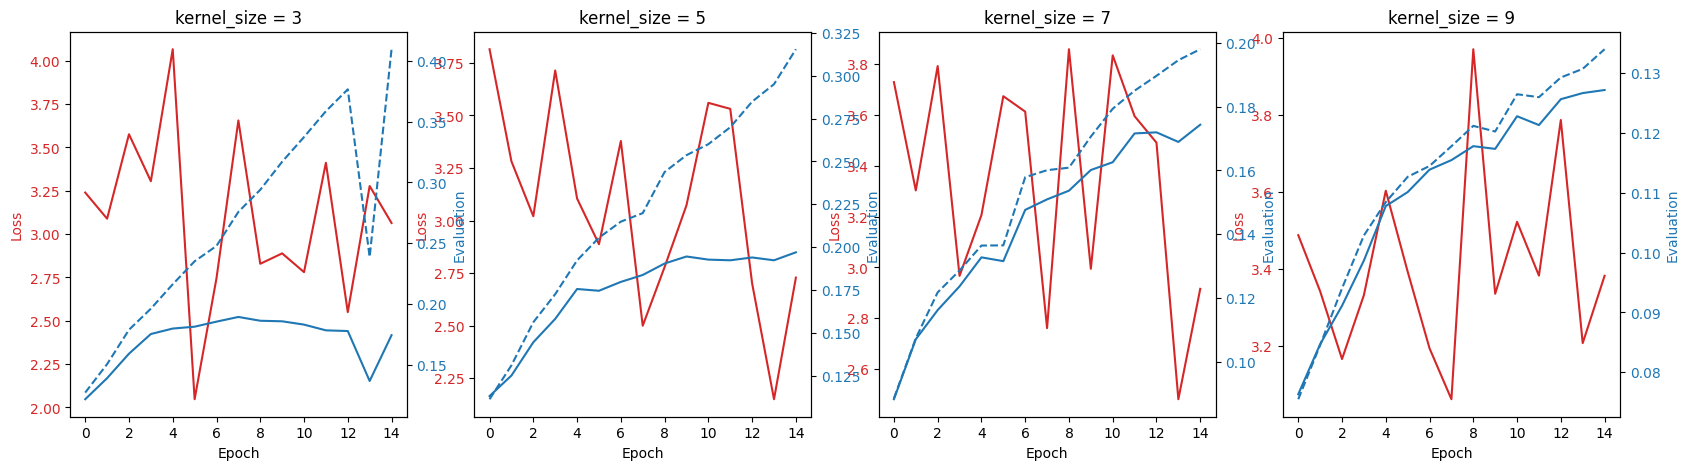

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, kernel_size in enumerate(kernel_size_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["kernel_size"] == kernel_size]["train_loss"].values[0]
    train_acc = res[res["kernel_size"] == kernel_size]["train_acc"].values[0]
    val_acc = res[res["kernel_size"] == kernel_size]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"kernel_size = {kernel_size}")

- Dla mniejszych wartości zbyt przetrenowany
- Dla większych bardzo słaba dokładność

### Stride

In [7]:
for stride in tqdm_notebook.tqdm(stride_values):
    n_channels = 10
    padding = 1
    n_convs = 2
    kernel_size = 3
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

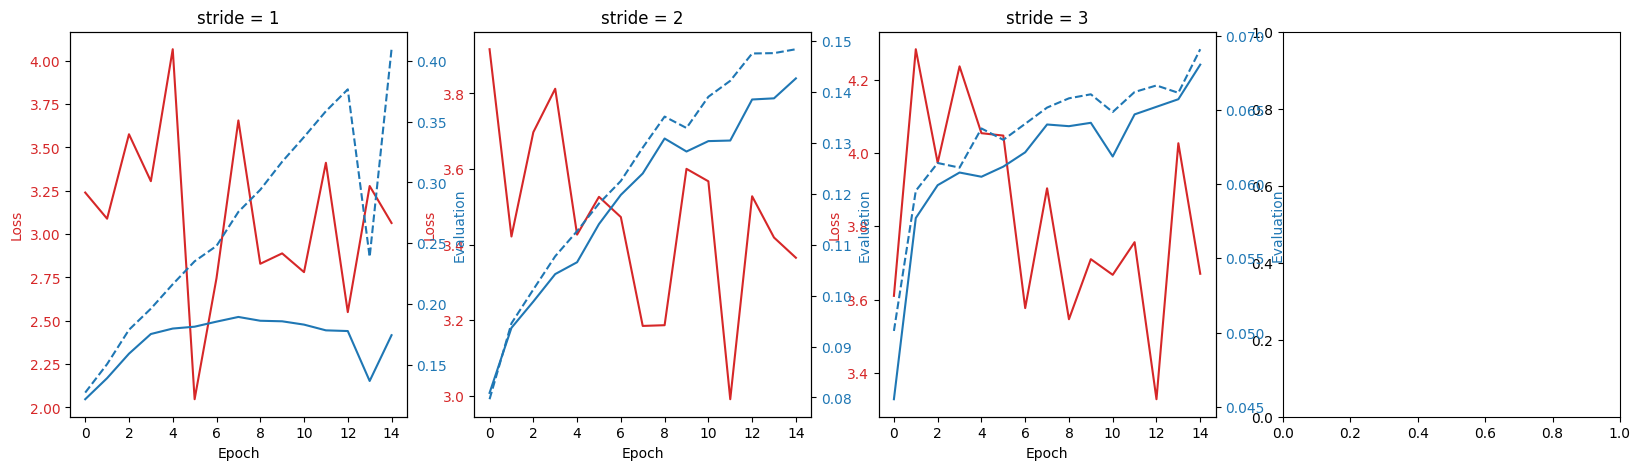

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, stride in enumerate(stride_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["stride"] == stride]["train_loss"].values[0]
    train_acc = res[res["stride"] == stride]["train_acc"].values[0]
    val_acc = res[res["stride"] == stride]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"stride = {stride}")

- Większy stride daje bardziej stabilne wyniki
- Gorsza ogólna dokładność ze zwiększeniem wartości

### Padding

In [8]:
for padding in tqdm_notebook.tqdm(padding_values):
    n_channels = 10
    n_convs = 2
    kernel_size = 3
    stride = 1
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

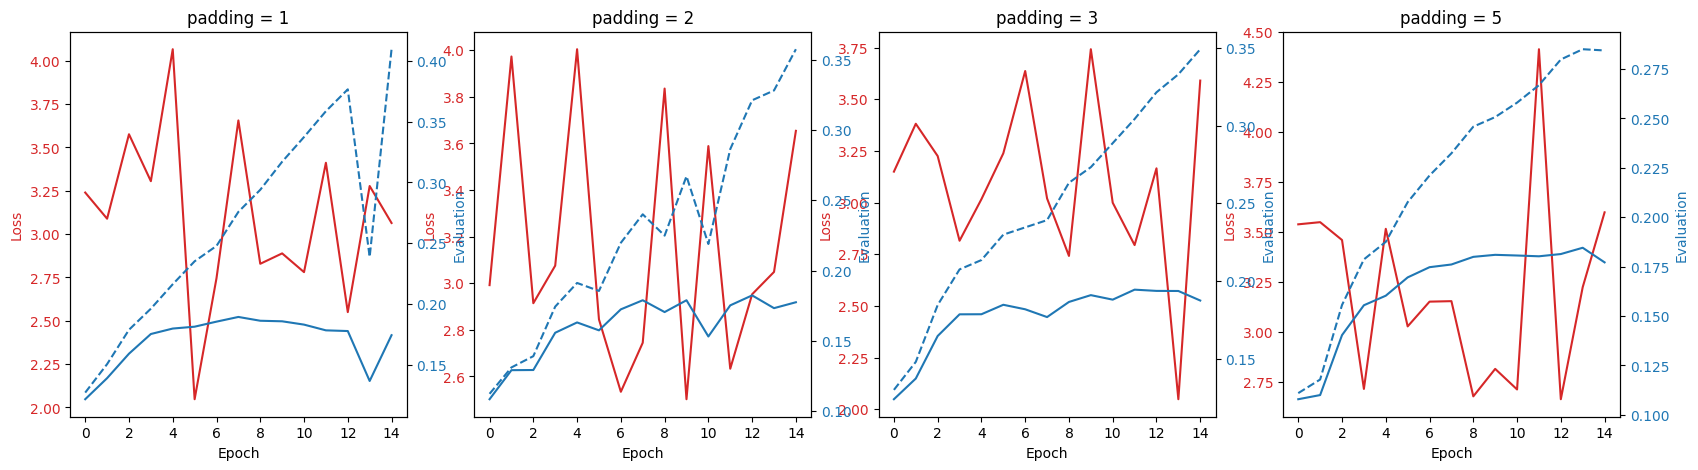

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, padding in enumerate(padding_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["padding"] == padding]["train_loss"].values[0]
    train_acc = res[res["padding"] == padding]["train_acc"].values[0]
    val_acc = res[res["padding"] == padding]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"padding = {padding}")

- Małe różnice w modelach
- Przy padding = 5 model robi się przetrenowany

### Liczba kanałów

In [9]:
for n_channels in tqdm_notebook.tqdm(n_channels_values):
    padding = 1
    n_convs = 2
    kernel_size = 3
    stride = 1
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convs, kernel_size=kernel_size, stride=stride, padding=padding, n_channels=n_channels).to(device)
    except:
        continue
    nets[(n_convs, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 15, verbose=False)
    model_res = pd.DataFrame([[n_convs, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    res = pd.concat([res, model_res])

  0%|          | 0/4 [00:00<?, ?it/s]

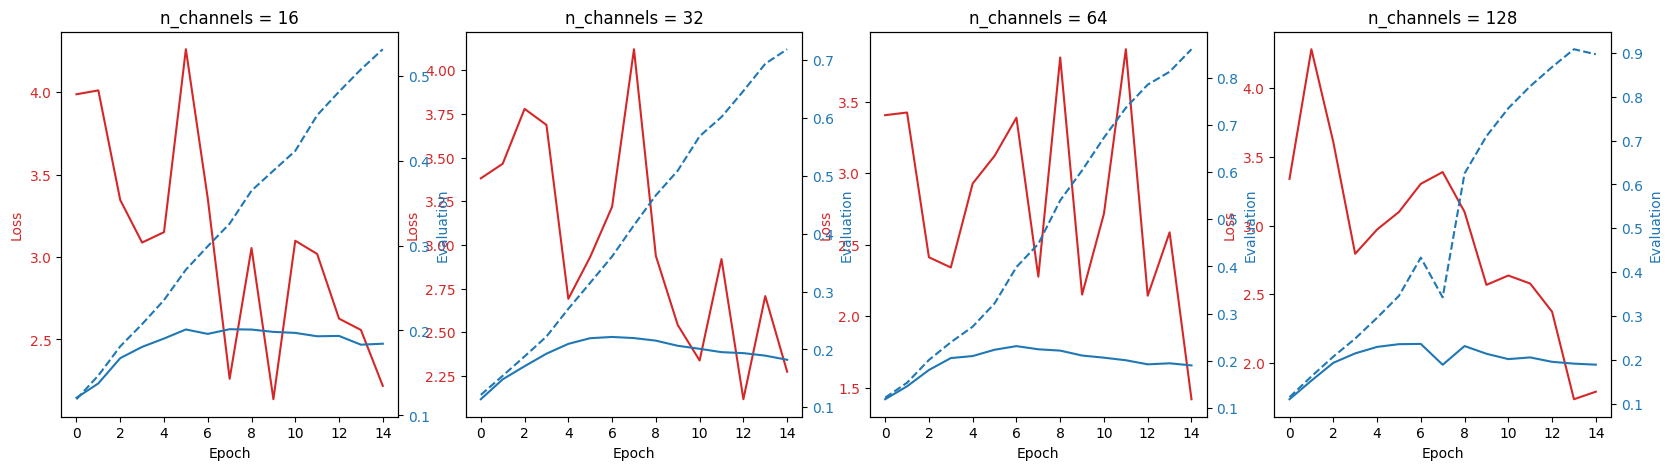

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, n_channels in enumerate(n_channels_values):
    iters = [i for i in range(15)]
    loss_hist = res[res["n_channels"] == n_channels]["train_loss"].values[0]
    train_acc = res[res["n_channels"] == n_channels]["train_acc"].values[0]
    val_acc = res[res["n_channels"] == n_channels]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"n_channels = {n_channels}")

- Zwiększanie liczby kanałów przetrnowuje model
- Duża różnica pomiędzy zbiorem walidacyjnym i treningowym
- Większe wartości pozwalają na większą stabilność modelu

## Eksperymenty na sieciach

In [5]:
from tqdm import notebook as tqdm_notebook

res = pd.DataFrame(columns=["n_convs", "kernel_size", "stride", "padding", "n_channels", "train_loss", "train_acc", "val_acc", "overfit"])
nets = {}
listofmodel=[[1,1,1,1,16],[2,5,1,1,16],[5,5,2,2,32],[2,3,2,2,32],[2,5,1,1,16]]
for parameters in tqdm_notebook.tqdm(listofmodel):
    n_convsact=parameters[0]  
    kernel_size = parameters[1]
    stride = parameters[2]
    padding = parameters[3]
    n_channels = parameters[4]
    try:
        net = CustomNet(num_classes=50, input_size=48, n_convs=n_convsact, kernel_size=kernel_size, stride=stride, padding=padding, n_channels=n_channels).to(device)
    except:
        continue
    nets[(n_convsact, kernel_size, stride, padding)] = net
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True, num_workers=8)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_hist, train_eval_hist, val_eval_hist = train_model(net, train_loader, val_loader, criterion, optimizer, get_accuracy, device, 50, verbose=False)
    model_res = pd.DataFrame([[n_convsact, kernel_size, stride, padding, n_channels,loss_hist, train_eval_hist, val_eval_hist, train_eval_hist[-1]-val_eval_hist[-1]]], columns=["n_convs", "kernel_size", "stride", "padding", "n_channels","train_loss", "train_acc", "val_acc", "overfit"])
    torch.save(net.state_dict(), "model"+str(n_convsact)+str(kernel_size)+str(stride)+str(padding)+str(n_channels)+".tar")
    res = pd.concat([res, model_res])
res.to_csv('wyniki_modeli.csv', index=False)


  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_7793/1528610515.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_res])


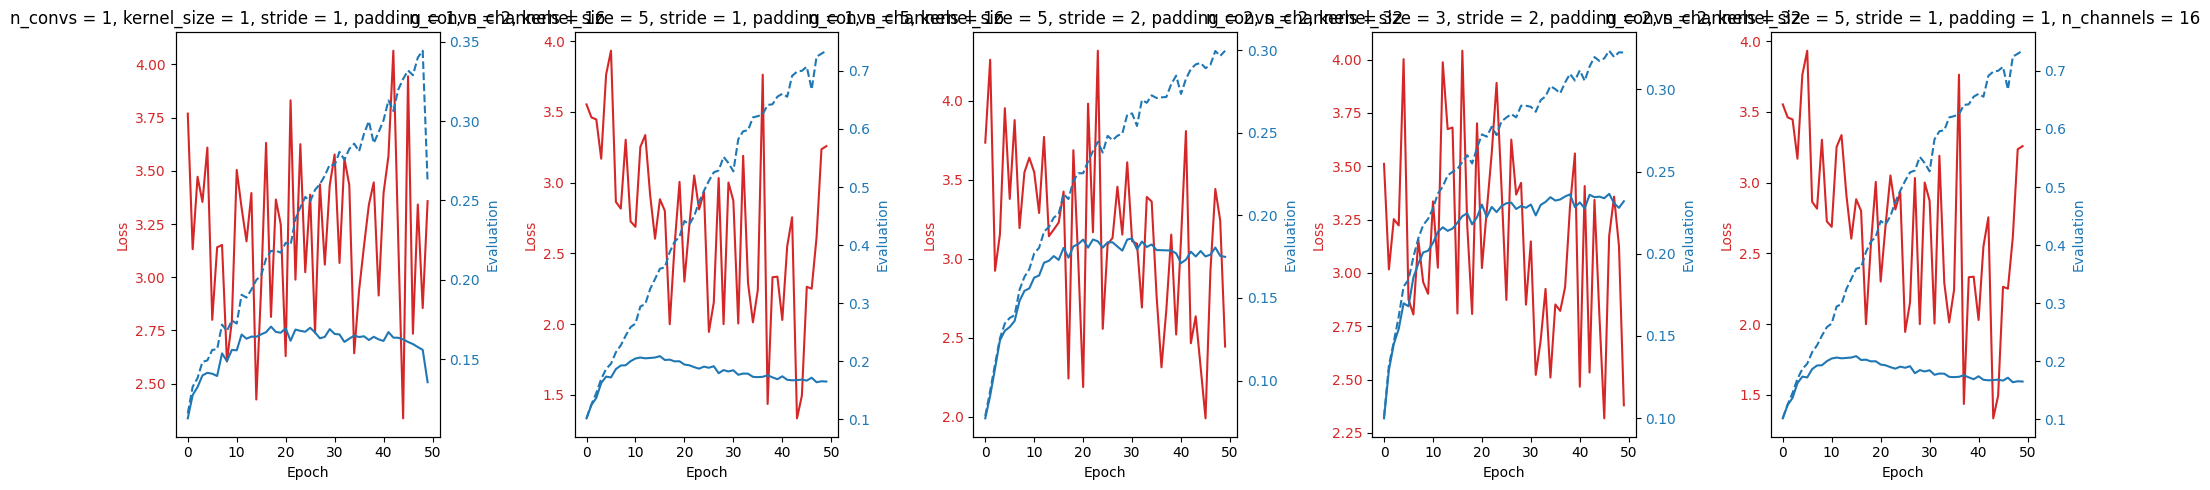

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, parameters in enumerate(listofmodel):
    n_convsact=parameters[0]  
    kernel_size = parameters[1]
    stride = parameters[2]
    padding = parameters[3]
    n_channels = parameters[4]
    iters = [i for i in range(50)]
    loss_hist = res[(res["n_convs"] == n_convsact) & (res["kernel_size"] == kernel_size) & (res["stride"] == stride) & (res["padding"] == padding) & (res["n_channels"] == n_channels)]["train_loss"].values[0]
    train_acc = res[(res["n_convs"] == n_convsact) & (res["kernel_size"] == kernel_size) & (res["stride"] == stride) & (res["padding"] == padding) & (res["n_channels"] == n_channels)]["train_acc"].values[0]
    val_acc = res[(res["n_convs"] == n_convsact) & (res["kernel_size"] == kernel_size) & (res["stride"] == stride) & (res["padding"] == padding) & (res["n_channels"] == n_channels)]["val_acc"].values[0]
    plot_training(iters, loss_hist, train_acc, val_acc, axs[i])
    axs[i].set_title(f"n_convs = {n_convsact}, kernel_size = {kernel_size}, stride = {stride}, padding = {padding}, n_channels = {n_channels}")
plt.tight_layout()
plt.show()

Balanced accuracy: 0.13357749581336975
Final accuracy: 0.13537465204794638


/tmp/ipykernel_7793/4266554760.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_score_sorted.keys()), y=list(label_score_sorted.values()), ax=ax, palette="viridis")


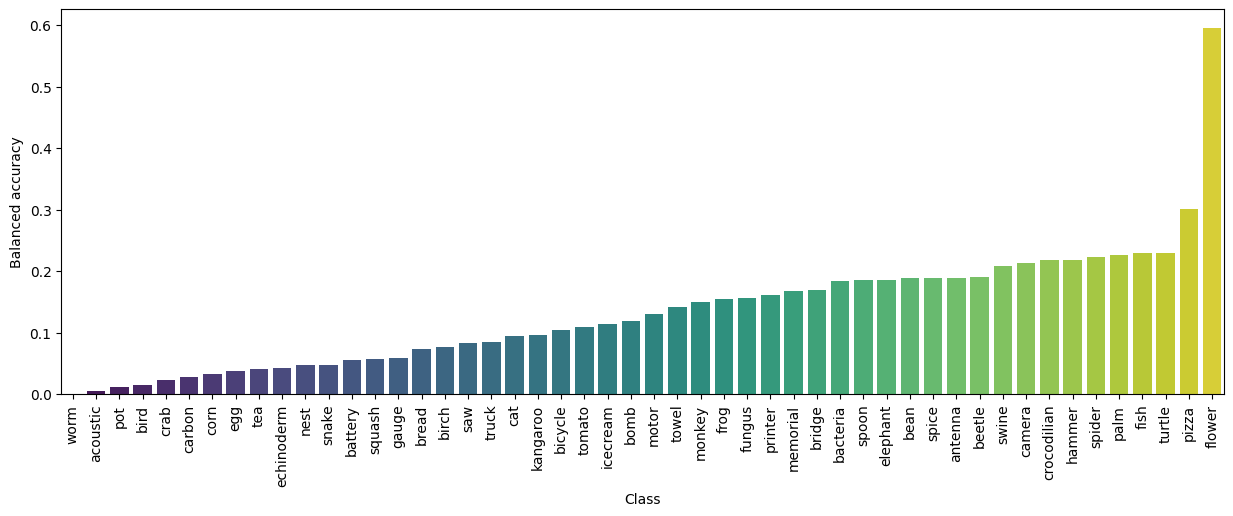

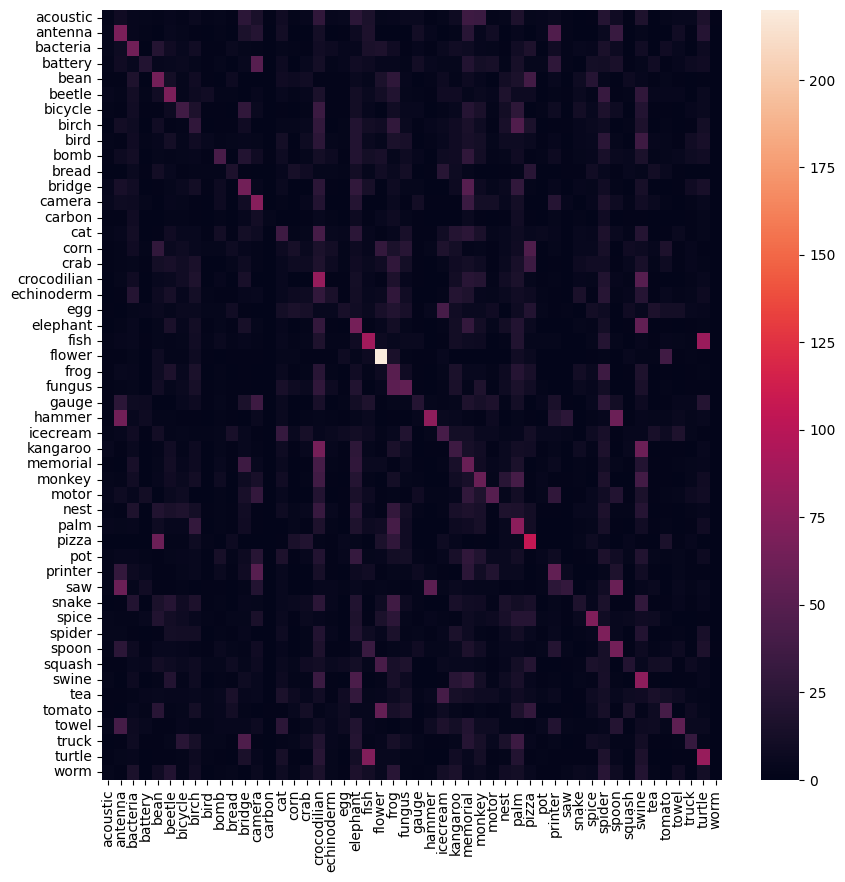

Balanced accuracy: 0.1469942033290863
Final accuracy: 0.14946315968868942


/tmp/ipykernel_7793/4266554760.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_score_sorted.keys()), y=list(label_score_sorted.values()), ax=ax, palette="viridis")


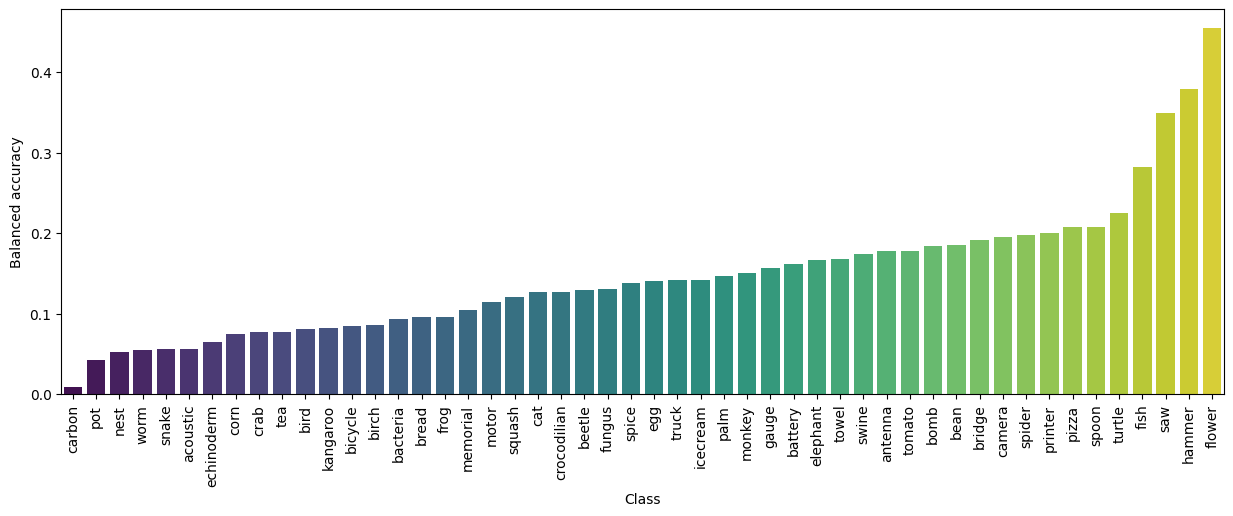

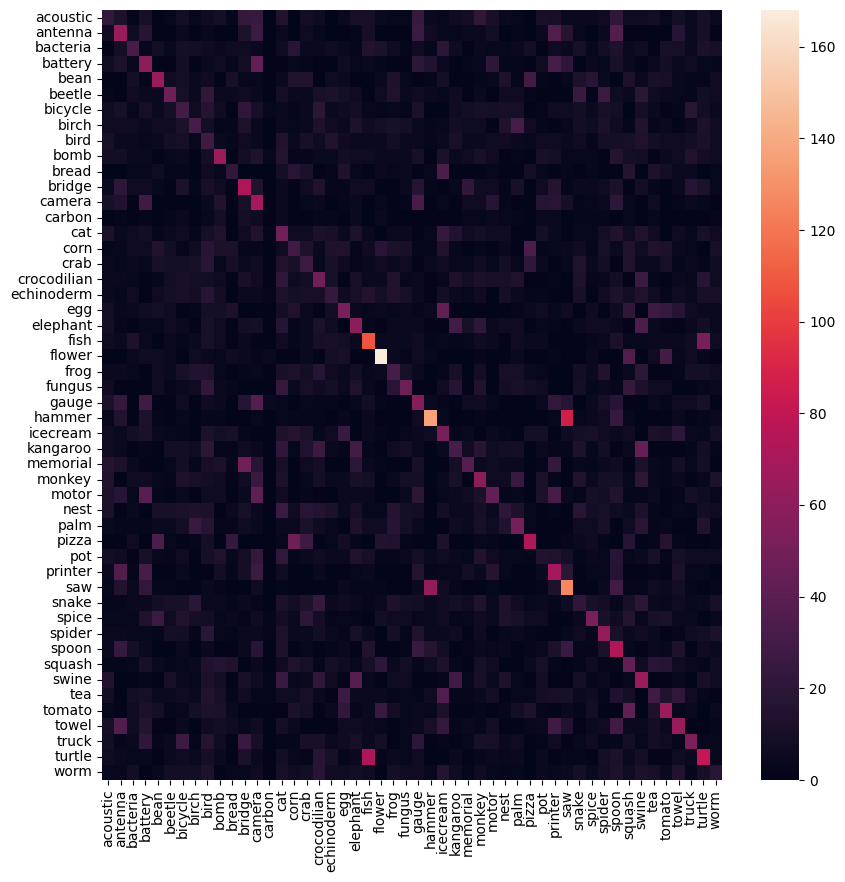

Balanced accuracy: 0.17219917476177216
Final accuracy: 0.17491336703970914


/tmp/ipykernel_7793/4266554760.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_score_sorted.keys()), y=list(label_score_sorted.values()), ax=ax, palette="viridis")


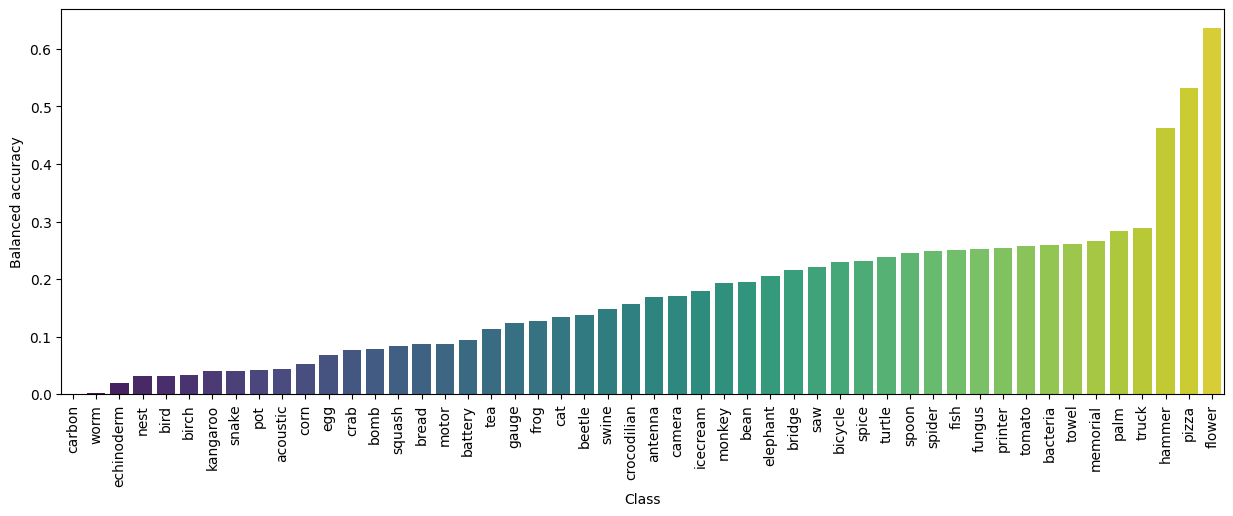

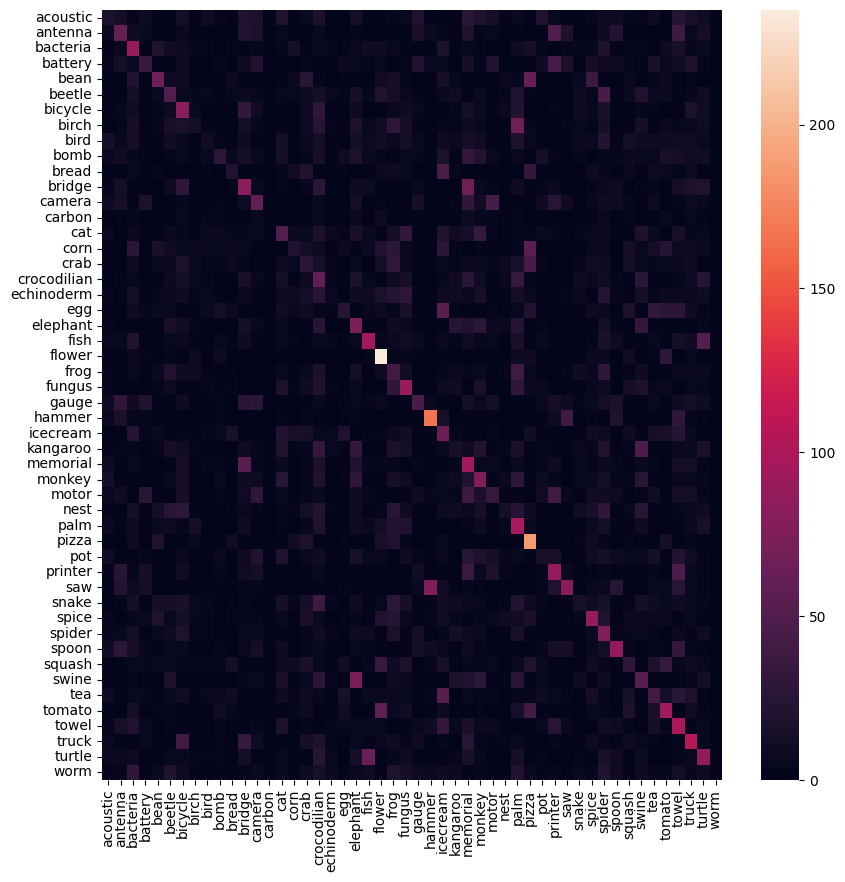

Balanced accuracy: 0.22903446853160858
Final accuracy: 0.23194909958529797


/tmp/ipykernel_7793/4266554760.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_score_sorted.keys()), y=list(label_score_sorted.values()), ax=ax, palette="viridis")


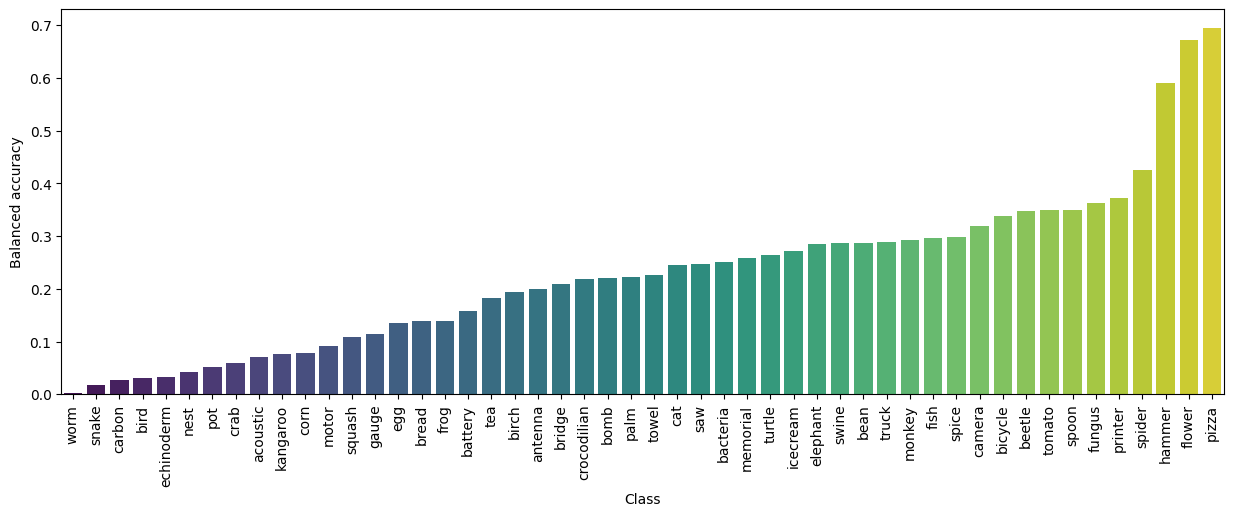

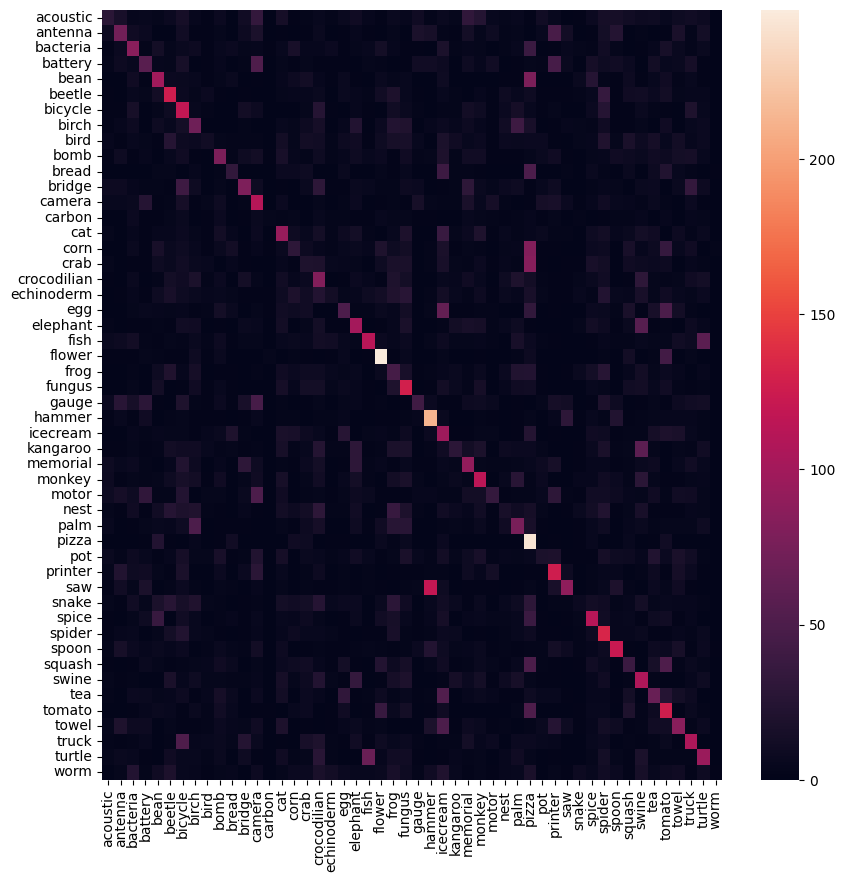

In [7]:
labels = ['acoustic', 'antenna', 'bacteria', 'battery', 'bean', 'beetle', 'bicycle', 'birch', 'bird', 'bomb', 'bread', 'bridge', 'camera', 'carbon', 'cat', 'corn', 'crab', 'crocodilian', 'echinoderm', 'egg', 'elephant', 'fish', 'flower', 'frog', 'fungus', 'gauge', 'hammer', 'icecream', 'kangaroo', 'memorial', 'monkey', 'motor', 'nest', 'palm', 'pizza', 'pot', 'printer', 'saw', 'snake', 'spice', 'spider', 'spoon', 'squash', 'swine', 'tea', 'tomato', 'towel', 'truck', 'turtle', 'worm']
for net in nets:
    balanced_accuracy_score, balanced_accuracy = get_balanced_accuracy(nets[net], classes=labels, data=val_loader, device=device)
    print(f"Balanced accuracy: {balanced_accuracy_score}")
    final_acc = get_accuracy(nets[net], val_loader, device)
    print(f"Final accuracy: {final_acc}")
    fig, ax = plt.subplots(figsize=(15, 5))
    label_score = {label: score for label, score in zip(labels, balanced_accuracy.numpy())}
    label_score_sorted = {k: v for k, v in sorted(label_score.items(), key=lambda item: item[1])}
    sns.barplot(x=list(label_score_sorted.keys()), y=list(label_score_sorted.values()), ax=ax, palette="viridis")
    plt.ylabel("Balanced accuracy")
    plt.xlabel("Class")
    plt.xticks(rotation=90)
    plt.show()
    confusion_matrix = get_confusion_matrix(nets[net], val_loader, classes=labels, device=device) 
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, ax=ax)
    plt.show()